# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [58]:
#importing some useful packages that we'll use else where
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Declare Useful Utility Methods

The starter notebook included these utilities. So let's declare them upfront.

In [59]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Create Function That Annotates A Single Frame

In [60]:
def hough_lines(img):
    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_len = 5
    max_line_gap = 3
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def calc_angle(x1,y1,x2,y2):
    """
    output theta and x at y=image_height  * 3 / 4.
    """
    return np.rad2deg(np.arctan2(y2-y1, x2-x1))

def find_right(lines, width):
    right_edges = list()
    for line in lines:
        x1,y1,x2,y2 = sort_line(line)
        angle = calc_angle(x1,y1,x2,y2)
        if angle > 120 and angle < 160 and x1 < width / 2 and x2 < width / 2:
            right_edges.append(line)
    return right_edges


def find_left(lines, width):
    right_edges = list()
    for line in lines:
        x1,y1,x2,y2 = sort_line(line)
        angle = calc_angle(x1,y1,x2,y2)
        if angle > 20 and angle < 60 and x1 > width / 2 and x2 > width / 2:
            right_edges.append(line)
    return right_edges

def draw_lines_to_point_list(img, lines, color=[255, 0, 0]):
    X = list()
    Y = list()
    
    thickness=5
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for x1,y1,x2,y2 in lines:
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness) 
    nonzeros = np.nonzero(line_img)
    for i in range(0, len(nonzeros[0])):
        X.append(nonzeros[1][i])
        Y.append(nonzeros[0][i])             
    return X,Y,line_img


def sort_line(line):
    """
    Sort a line so that its first point is higher up
    """
    x1,y1,x2,y2 = line
    if y1 < y2:
        return (x1,y1,x2,y2)
    return (x2,y2, x1,y1)

def cull_lines(lines):
    culled_lines = list()
    for line in lines:
        x1,y1,x2,y2 = sort_line(line)
        angle = calc_angle(x1,y1,x2,y2)
        if angle > 20 and angle < 60:
            culled_lines.append( (x1,y1,x2, y2))
        if angle > 120 and angle < 160:
            culled_lines.append( (x1,y1,x2, y2))
    return culled_lines
            
def linear_regression(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return (m, c)    

def draw_regression_image_on_top(root_image, m, c):
    y1 = root_image.shape[0] * 0.6 # draw to horizon
    x1 = (y1 - c) / m
    y2 = root_image.shape[0]
    x2 = (y2 - c) / m
    
    color = [255,0,0]
    thickness = 5
    cv2.line(root_image, (int(round(x1)), int(round(y1))), (int(round(x2)), int(round(y2))), color, thickness)
     
def unpack_lines(lines):
    rlines = list()
    for line in lines:
        for x1,y1,x2,y2 in line:
            rlines.append((x1,y1,x2,y2))
    return rlines
        
def process_right(image, edges_image, lines):
    right_lines = find_right(lines, edges_image.shape[1])
    X,Y,right_points = draw_lines_to_point_list(edges_image, right_lines)
    m, c = linear_regression(X,Y)
    draw_regression_image_on_top(image, m, c)
    
def process_left(image, edges_image, lines):
    right_lines = find_left(lines, edges_image.shape[1])
    X,Y,right_points = draw_lines_to_point_list(edges_image, right_lines)
    m, c = linear_regression(X,Y)
    draw_regression_image_on_top(image, m, c)
        

def get_edges(image):
    # throw out color information
    grayscale_image = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(grayscale_image, kernel_size)
    
    low_threshold = 100
    high_threshold = 200
    canny_image = canny(blur_gray, low_threshold, high_threshold)
    return canny_image

        
def overlay_highlights(image):
    # detect edges. Then throw out edges outside the boundary.
    edges_image = get_edges(image)
    vertices = np.array([[
        (0 * 0.4,edges_image.shape[0]), # bottom left
        (edges_image.shape[1] * 0.4, edges_image.shape[0]* 0.6), # top left
        (edges_image.shape[1] * 0.6, edges_image.shape[0]* 0.6), # top right
        (edges_image.shape[1],edges_image.shape[0])
        ]], dtype=np.int32)
    edges_image = region_of_interest(edges_image, vertices)
    
    lines = hough_lines(edges_image)
    lines = unpack_lines(lines)
    lines = cull_lines(lines) # maybe can get rid of this
    
    process_right(image, edges_image, lines)
    process_left(image, edges_image, lines)


## Let's Try This Out On Individual Frames

We'll apply the above transformation to all the individual test frames we were given.


processing image: solidWhiteCurve.jpg
processing image: solidWhiteRight.jpg
processing image: solidYellowCurve.jpg
processing image: solidYellowCurve2.jpg
processing image: solidYellowLeft.jpg
processing image: whiteCarLaneSwitch.jpg


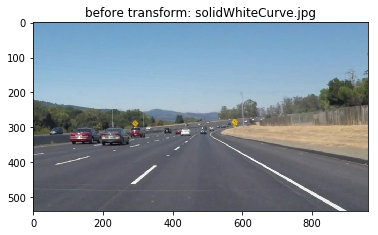

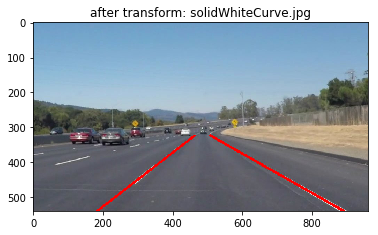

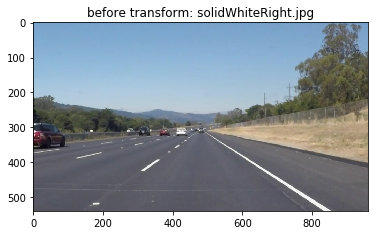

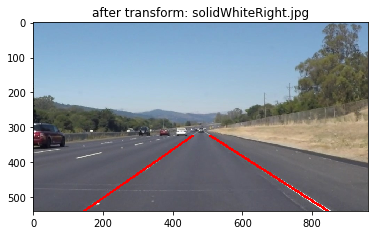

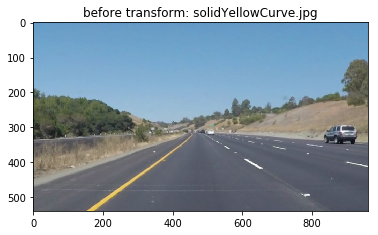

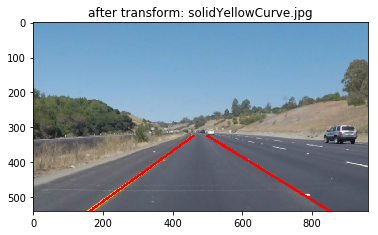

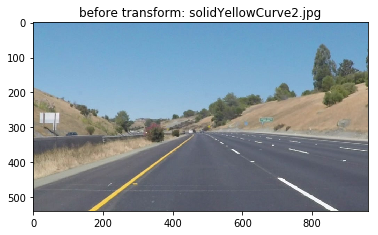

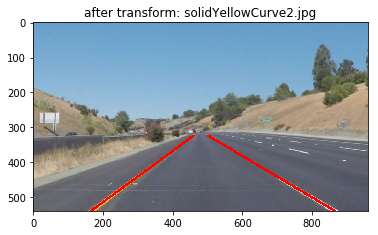

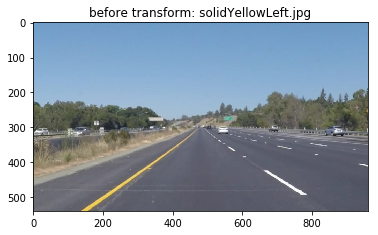

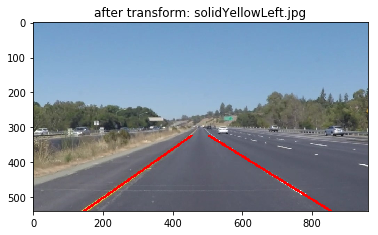

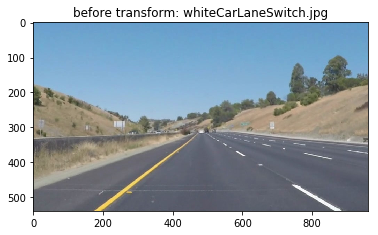

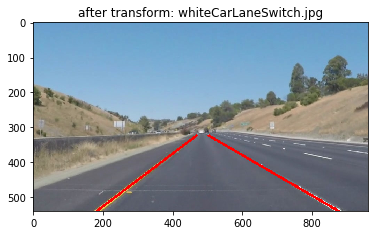

In [61]:
import os
for image_name in os.listdir("test_images/"):
    image = mpimg.imread('test_images/' + image_name)
    print ("processing image: " + image_name)
    
    plt.figure('before transform: ' + image_name)
    plt.title('before transform: ' + image_name)
    plt.imshow(image)
    
    overlay_highlights(image)
    
    plt.figure('after transform: ' + image_name)
    plt.title('after transform: ' + image_name)
    plt.imshow(image) 


## Processing Videos

Now let's setup a function to process videos. Note how this uses the image pipeline from above.

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio

# Install ffmpeg if necessary
imageio.plugins.ffmpeg.download()

import copy

def process_image(image):
    # doing this copy fixes a bug that would otherwise occur
    # in the first frame of the video. 
    image = copy.copy(image)
    overlay_highlights(image)
    return image

def process_video(input_file_name, output_file_name):
    ##You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(input_file_name)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_file_name, audio=False)

# Test On White Lines

In [63]:
input_file_name = "test_videos/solidWhiteRight.mp4"
white_output = 'test_videos_output/solidWhiteRight.mp4'
process_video(input_file_name, white_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
# change to white_output
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.03 s, sys: 712 ms, total: 7.74 s
Wall time: 6.99 s


# Test On White and Yellow Lines

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [64]:
input_file_name = 'test_videos/solidYellowLeft.mp4'
output_file_name = 'test_videos_output/solidYellowLeft.mp4'
process_video(input_file_name, white_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file_name))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 681/682 [00:20<00:00, 33.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 21.3 s, sys: 2.2 s, total: 23.5 s
Wall time: 20.5 s


## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
